#  Stock Hold Time Calculation
- Characterize the hold time(s) of a series of buys and sells in shares
of a given symbol.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%%bash

ls data/eventus/*.csv

data/eventus/sample_data.csv


## Plot Time-Series
- Show trades over time

In [3]:
txns = pd.read_csv('data/eventus/sample_data.csv')
txns['delta'] = txns.qty 
txns.loc[txns.buy_sell == 'sell', 'delta'] = -txns.qty 
txns['CumSum'] = txns.delta.cumsum()
txns.loc[:, ['tm', 'buy_sell', 'qty', 'CumSum']].head()

,tm,buy_sell,qty,CumSum
0,1531492972,buy,2000,2000
1,1531492974,buy,1000,3000
2,1531493224,sell,550,2450
3,1531493225,sell,600,1850
4,1531493232,sell,100,1750


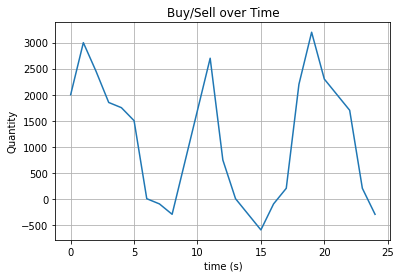

In [4]:
fig, ax = plt.subplots()
ax.plot(txns.index, txns.CumSum)
ax.set(xlabel='time (s)', ylabel='Quantity', title='Buy/Sell over Time')
ax.grid()
plt.show()

## Algorithm for Calculating Hold Time
- Use a stack to keep track of the buy time for each stock purchase
- Maintain a running average of weighted hold times each time a stock is sold and matches a buy order
- For each sell transaction:
    1. Pop the most recent stock purchase from the stack
    2. Use the sell quantity + hold time to update the running average hold time
    3. Push the updated stock quantity back onto the stack
    
### Assumptions
- Ignore transactions for which there is no matching stock purchase
- If a sell order exceeds the remaining buy order, then sell only what remains
- When matching sales to purchases, the most recent stock purchase is used

### Complexity
For input n:
- Runtime: O(n**2)
- Storage: O(n)

In [5]:
stack = []
stock_total = ev_total = 0

for txn in txns.loc[:, ['tm', 'buy_sell', 'qty']].itertuples(index=False):
    if txn.buy_sell == 'buy':
        stack.append((txn.tm, txn.qty))
    else:
        tmp_qty = txn.qty
        
        while stack and tmp_qty:
            
            last_time, last_buy = stack.pop()
            new_balance = last_buy - tmp_qty

            if new_balance > 0:
                stock_total += tmp_qty
                ev_total += tmp_qty*(txn.tm - last_time)
                stack.append((last_time, new_balance))
                
                break
            else:
                stock_total += last_buy
                ev_total += last_buy*(txn.tm - last_time)
                tmp_qty -= last_buy

## Result

In [6]:
print(f"Average hold time = {ev_total}s/{stock_total} = {(ev_total/stock_total):.2f}s")

Average hold time = 6167194s/9500 = 649.18s
